# Prosper Loan Data Exploration

## by Dmitry Zmienko

## Investigation Overview

In this investigation, I planned to look what influence borrower's annual percentage rate (APR) and understand the Prosper company's lending policy. 

## Dataset Overview
The dataset by company Prosper contains 113,937 loans with 81 variables on each loan from 2005 to 2014. For the purpose of the investigation I left only data afrom July 2009 (when Prosper issued their own rating system) and explore only group of variables: 
1. Data that describes Listing: 'ListingKey', 'ListingCreationDate', 'Term', 'LoanStatus', 'BorrowerAPR',  'ProsperRating (Alpha)', 'ProsperScore', 'ListingCategory (numeric)'.
2. Data that describes Borrower: 'BorrowerState', 'Occupation', 'EmploymentStatus', 'IsBorrowerHomeowner', 'CreditScoreRangeLower', 'CreditScoreRangeUpper', 'IncomeRange', 'IncomeVerifiable', 'StatedMonthlyIncome'.
3. Data that describes Loan: 'TotalProsperLoans', 'LoanOriginalAmount', 'LoanOriginationDate', 'MonthlyLoanPayment', 'Recommendations'.

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import matplotlib.gridspec as gridspec

%matplotlib inline

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

# Set up the color palette to use
base_color = sns.color_palette()[0]

# Create function for labeling plots
def x_y_t(x_label, y_label, title):
    plt.title(title, fontsize=16)
    plt.xlabel(x_label, fontsize=14)
    plt.ylabel(y_label, fontsize=14)

In [2]:
# load in the dataset into a pandas dataframe
df_origin = pd.read_csv('prosperLoanData.csv')

# Create data frame with selected columns
selected_columns = ['ListingKey', 'ListingCreationDate', 'Term', 'LoanStatus', 'BorrowerAPR', 'ProsperRating (Alpha)', 'ProsperScore', 'ListingCategory (numeric)', 'BorrowerState', 'Occupation', 'EmploymentStatus', 'IsBorrowerHomeowner', 'CreditScoreRangeLower', 'CreditScoreRangeUpper', 'IncomeRange', 'IncomeVerifiable', 'StatedMonthlyIncome', 'TotalProsperLoans', 'LoanOriginalAmount', 'LoanOriginationDate', 'MonthlyLoanPayment', 'Recommendations']
df=df_origin[selected_columns]

In [3]:
# Rename columns
df = df.rename(columns={'ListingCategory (numeric)': 'ListingCategory',
                        'ProsperRating (Alpha)': 'ProsperRating'})

# Drop missing values in ProsperRating (leave data only since July 2009)
df = df.dropna(subset=['ProsperRating']).reset_index()

# Copy column with Prosper score as numerical
df['Prosper Score Num'] = df.ProsperScore

In [4]:
# Converte some columns into ordered categorical types
var_dict = {'Term': [12, 36, 60],
            'LoanStatus': ['Completed', 'FinalPaymentInProgress', 'Current', 'Cancelled',
                           'Past Due (1-15 days)', 'Past Due (16-30 days)', 'Past Due (31-60 days)',
                           'Past Due (61-90 days)', 'Past Due (91-120 days)', 'Past Due (>120 days)',
                           'Defaulted', 'Chargedoff'],
            'ProsperRating': ['HR','E','D','C','B','A','AA'],
            'ProsperScore': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
            'IncomeRange': ['Not employed', '$0', '$1-24,999', '$25,000-49,999', '$50,000-74,999',
                             '$75,000-99,999','$100,000+'],
            'EmploymentStatus': ['Employed', 'Full-time', 'Self-employed', 'Other', 'Part-time', 'Not employed', 'Retired']}

for i in var_dict:
    order_cat = pd.api.types.CategoricalDtype(ordered = True, categories = var_dict[i])
    df[i] = df[i].astype(order_cat)

In [5]:
# In the column ListingCategory compare the numbers with their semantic meanings and convert to a categorical variable
ListingCategory_number = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
ListingCategory_value = ['Not Available','Debt Consolidation', 'Home Improvement', 'Business', 
            'Personal Loan', 'Student Use', 'Auto', 'Other', 'Baby&Adoption', 
            'Boat', 'Cosmetic Procedure', 'Engagement Ring', 'Green Loans', 
            'Household Expenses', 'Large Purchases', 'Medical/Dental', 'Motorcycle', 
            'RV', 'Taxes', 'Vacation', 'Wedding Loans']
df['ListingCategory'].replace(ListingCategory_number, ListingCategory_value, inplace = True)

ListingCategory_cat = pd.api.types.CategoricalDtype(ordered = False, categories = ListingCategory_value)
df['ListingCategory'] = df['ListingCategory'].astype(ListingCategory_cat)

In [6]:
# Add a column with an average of two values (upper and lower) and leave only this column
df['CreditScore'] = (df.CreditScoreRangeLower + df.CreditScoreRangeUpper) /2
df.drop(['CreditScoreRangeLower', 'CreditScoreRangeUpper'], axis=1, inplace=True)

## Distribution of borrower's APR

Annual Percentage Rate (APR) is the interest charged for borrowing that represents the actual yearly cost of the loan expressed as a percentage.
BorrowerAPR distribution looks normal (with the mean around 22%) except peak of around 36%. Most of the loans are in 10-36%

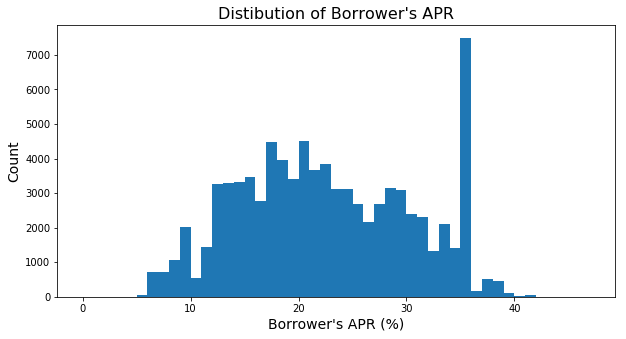

In [7]:
# Plot the distrubution of BorrowerAPR
plt.figure(figsize = (10,5))
bin = np.arange(0, df.BorrowerAPR.max()+0.05, 0.01)
plt.hist(data = df, x = 'BorrowerAPR', bins = bin);
x_y_t("Borrower's APR (%)", "Count", "Distibution of Borrower's APR")
plt.xticks([0.0, 0.1, 0.2, 0.3, 0.4,], 
           ['0', '10', '20', '30', '40']);

## Distribution of loan amount and term

Prosper company issues loans in a fairly narrow range from 1000 to 35000 for a period of 1, 3 or 5 years. The distribution of loan amount is skewed to the right, most of the borrowers take smaller loans. There is a spike at every 5000 dollar value which is most likely due to the fact that people obtain loans in rounded figure values.36 months is the most common loan period.

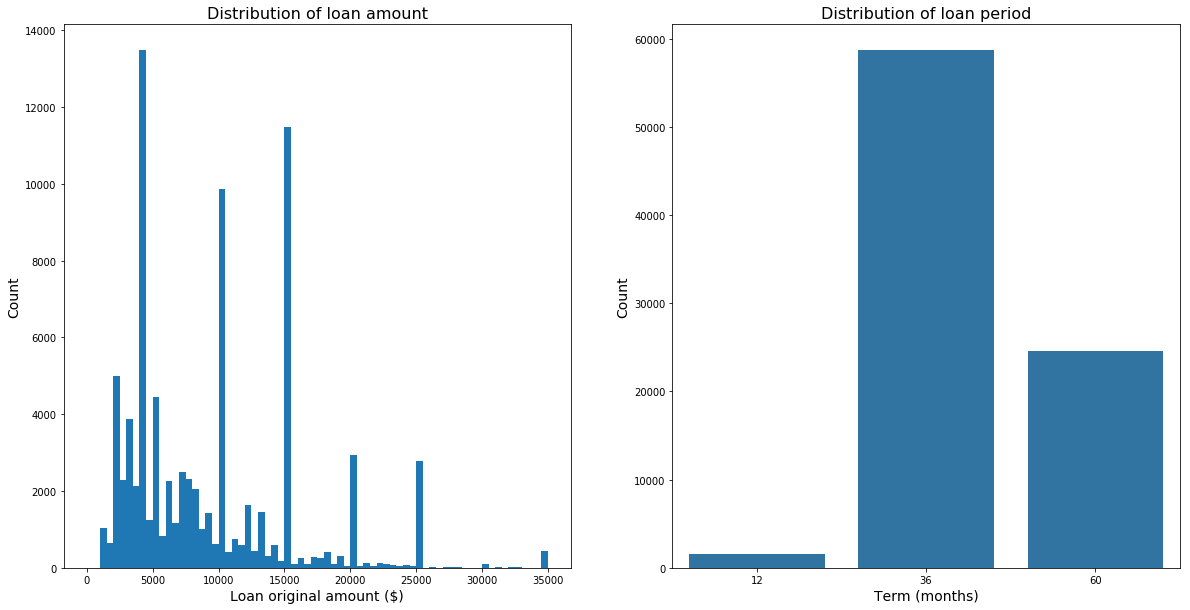

In [8]:
# Plot the distribution of loan amount and term
plt.figure(figsize = [20, 10])
plt.subplot(1, 2, 1)
bin = np.arange(0, df.LoanOriginalAmount.max()+100, 500)
plt.hist(data = df, x = 'LoanOriginalAmount', bins = bin)
x_y_t('Loan original amount ($)', 'Count', 'Distribution of loan amount');

plt.subplot(1, 2, 2)
sns.countplot(data = df, x='Term', color = base_color);
x_y_t('Term (months)', 'Count', 'Distribution of loan period');

## Correlation between borrower's APR, his Prosper rating/Credit score and loan amount

Despite the fact that we see an almost direct relationship between the borrower's APR and the borrower's scores (Prosper's rating or Credit  scores), we can argue that these values are not the only ones that determine the interest rate of a loan. On the top two charts, for each value, we see a wide range of APR values. Also, a significant impact on the borrower's APR is affected by the amount of the loan, but taking into account other factors, which we will discuss later.

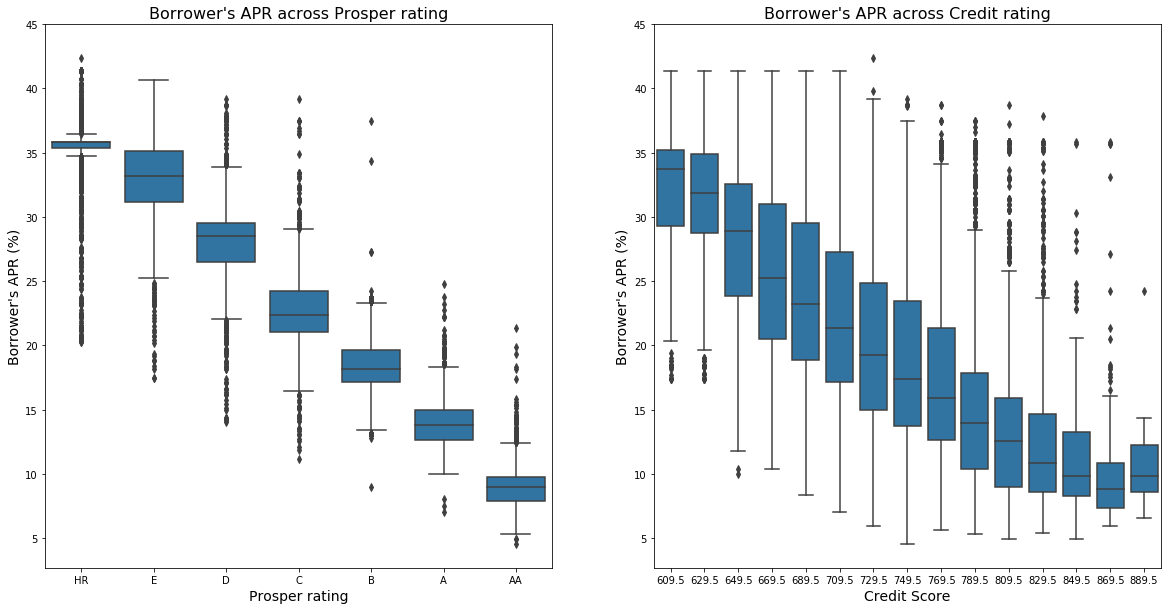

In [9]:
plt.figure(figsize = [20, 10])

# plot the correlation between borrower's APR and Prosper rating and Credit score
plt.subplot(1, 2, 1)
sns.boxplot(x=df.ProsperRating, y=df.BorrowerAPR, color=base_color)
x_y_t('Prosper rating', "Borrower's APR (%)", "Borrower's APR across Prosper rating")
plt.yticks([0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45], 
           ['5', '10', '15', '20', '25', '30', '35', '40', '45']);

plt.subplot(1, 2, 2)
sns.boxplot(x=df.CreditScore, y=df.BorrowerAPR, color=base_color)
x_y_t('Credit Score', "Borrower's APR (%)", "Borrower's APR across Credit rating")
plt.yticks([0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45], 
           ['5', '10', '15', '20', '25', '30', '35', '40', '45']);


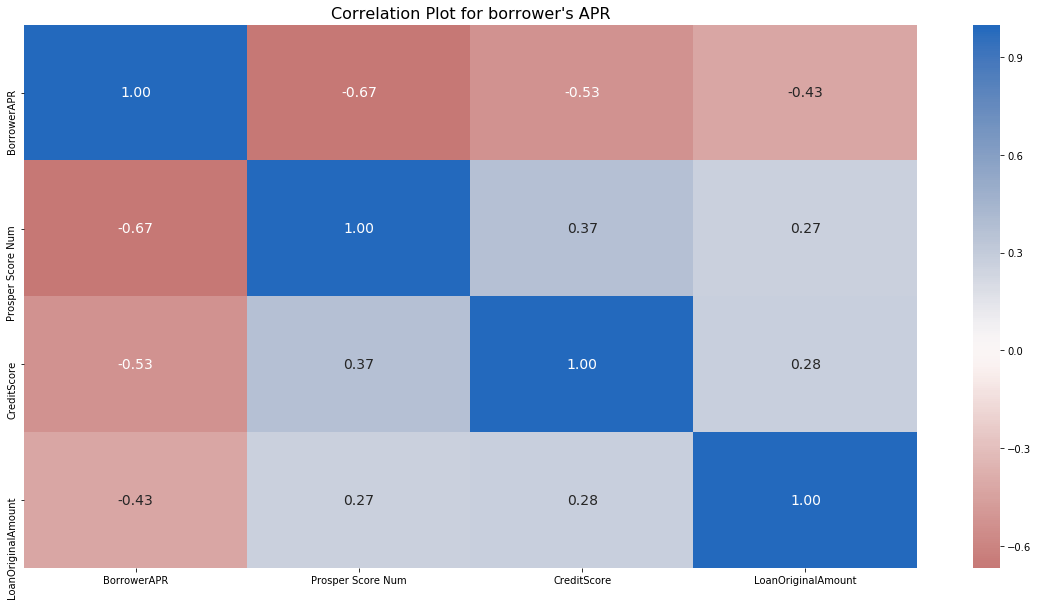

In [10]:
# plot heatmap to look on correlations between borrower's APR and other numerical variables
plt.figure(figsize = [20, 10])
cor_vars = ['BorrowerAPR', 'Prosper Score Num', 'CreditScore', 'LoanOriginalAmount']
sns.heatmap(df[cor_vars].corr(), annot = True, fmt = '.2f',
           cmap = 'vlag_r', center = 0,
           annot_kws={'fontsize': 14});
plt.title("Correlation Plot for borrower's APR", fontsize=16);

## Borrower's APR dependence on income

Looking only at the dependence of the borrower's APR on the income range, then, as expected, we will see that, for non-working and borrowers with lower income, the annual interest rate is higher. But if you look deeper into the distribution of monthly income, then despite a particular negative relationship between the borrower's APR and monthly income, we'll see that the spread of values is too large (for example, for monthly income more than $50K, most points are above a linear relationship). So the borrower's income weakly influences APR. 

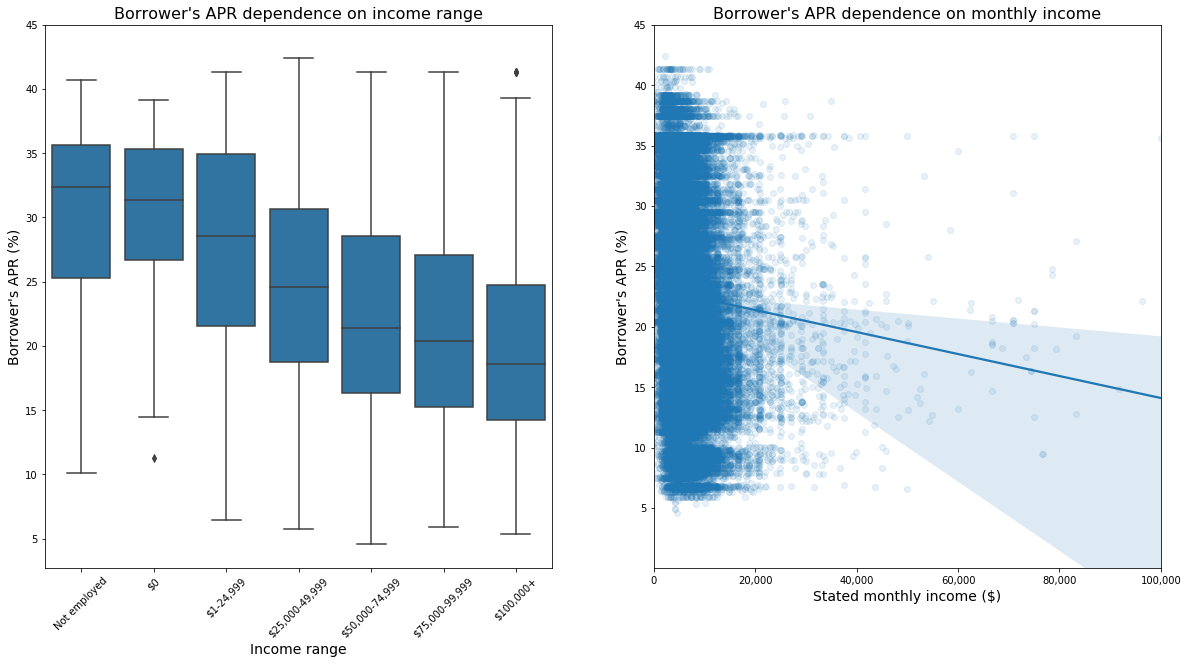

In [11]:
# Plot the distribution of borrower'a APR vs his income
plt.figure(figsize = [20, 10])

plt.subplot(1, 2, 1)
sns.boxplot(x=df.IncomeRange, y=df.BorrowerAPR, color=base_color)
x_y_t('Income range', "Borrower's APR (%)", "Borrower's APR dependence on income range")
plt.yticks([0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45], 
           ['5', '10', '15', '20', '25', '30', '35', '40', '45'])
plt.xticks(rotation = 45);

plt.subplot(1, 2, 2)
sns.regplot(data=df, x="StatedMonthlyIncome", y="BorrowerAPR", x_jitter=100, scatter_kws={'alpha':1/10})
plt.xlim(0, 100000)
plt.ylim(0, 0.45)
x_y_t('Stated monthly income ($)', "Borrower's APR (%)", "Borrower's APR dependence on monthly income")
plt.xticks([0, 20000, 40000, 60000, 80000, 100000], 
           ['0', '20,000', '40,000', '60,000', '80,000', '100,000'])
plt.yticks([0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45], 
           ['5', '10', '15', '20', '25', '30', '35', '40', '45']);

## Dependence of the borrower's APR on the Prosper rating and term

For lower ratings (E and HR), it's hard to get a loan for more than $10000, and the APR will be high (20-40%). For high-rated borrowers, we see that APR doesn't depend on the loan amount. But it is striking that for high-rated borrowers APR for bigger loans even increasing. On the contrary, the low-rated borrowers get lower APR for a bigger loan. Let's assume that this is due to company policy. Higher-ranked customers are more likely to be long-term and loyal to the brand (which is also confirmed by the higher APR for the credit rating of "890" compared to "870"). Customers with low ratings are primarily new clients, so the company is trying to attract them with a low APR.

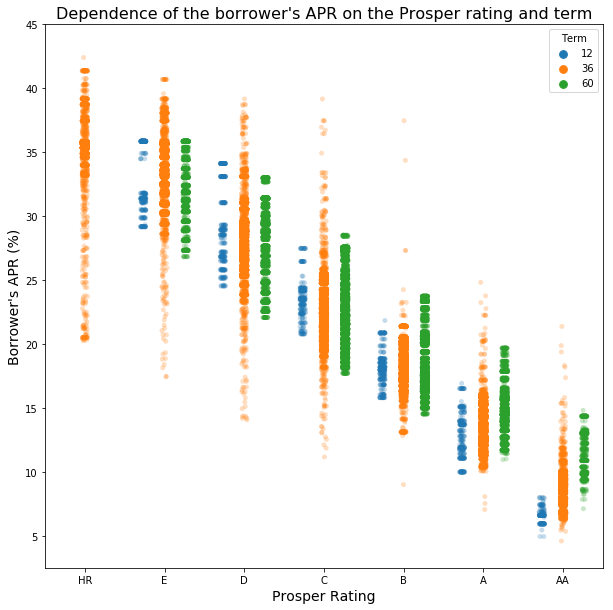

In [12]:
# plot borrower's APR vs prosper rating across terms
plt.figure(figsize = [10, 10])
sns.stripplot(data = df, x='ProsperRating', y='BorrowerAPR', dodge=True, hue='Term', jitter=True, alpha=.25)
x_y_t('Prosper Rating', "Borrower's APR (%)", "Dependence of the borrower's APR on the Prosper rating and term")
plt.yticks([0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45], 
           ['5', '10', '15', '20', '25', '30', '35', '40', '45']);

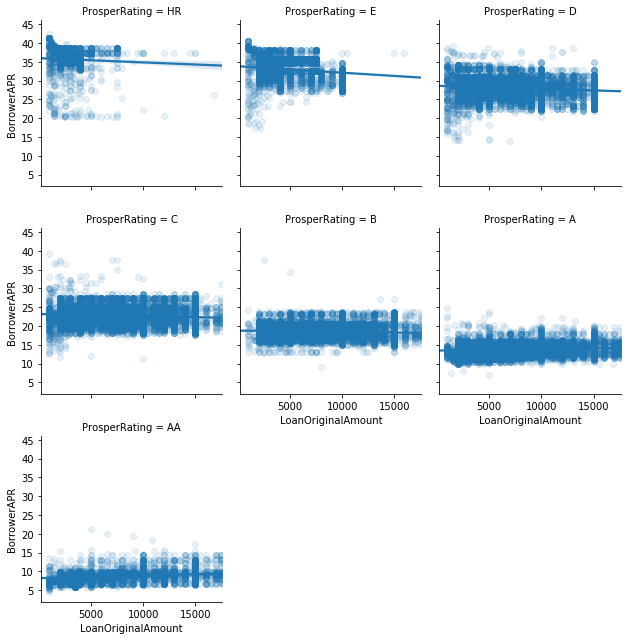

In [13]:
# Use FacetGrid to look deeply on correlation between Prosper rating, borrower's APR and loan amount
plt.figure(figsize = [10, 20])
g = sns.FacetGrid(data = df, col = 'ProsperRating', col_wrap=3);
g.map(sns.regplot, 'LoanOriginalAmount', 'BorrowerAPR', scatter_kws={'alpha':0.1});
plt.yticks([0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45], 
           ['5', '10', '15', '20', '25', '30', '35', '40', '45']);

## How borrower's profile (empoyment status, home ownership,  influence on borrower's APR?

Ownership of real estate reduces the risks for the lender. Same works for the employment status: employed borrowers tend to have lower APR. Highly qualified borrowers receive better loan offers. Loans for students for a technical school are allocated separately, a narrow spread of values shows that there is apparently some kind of specialized lending program for them.

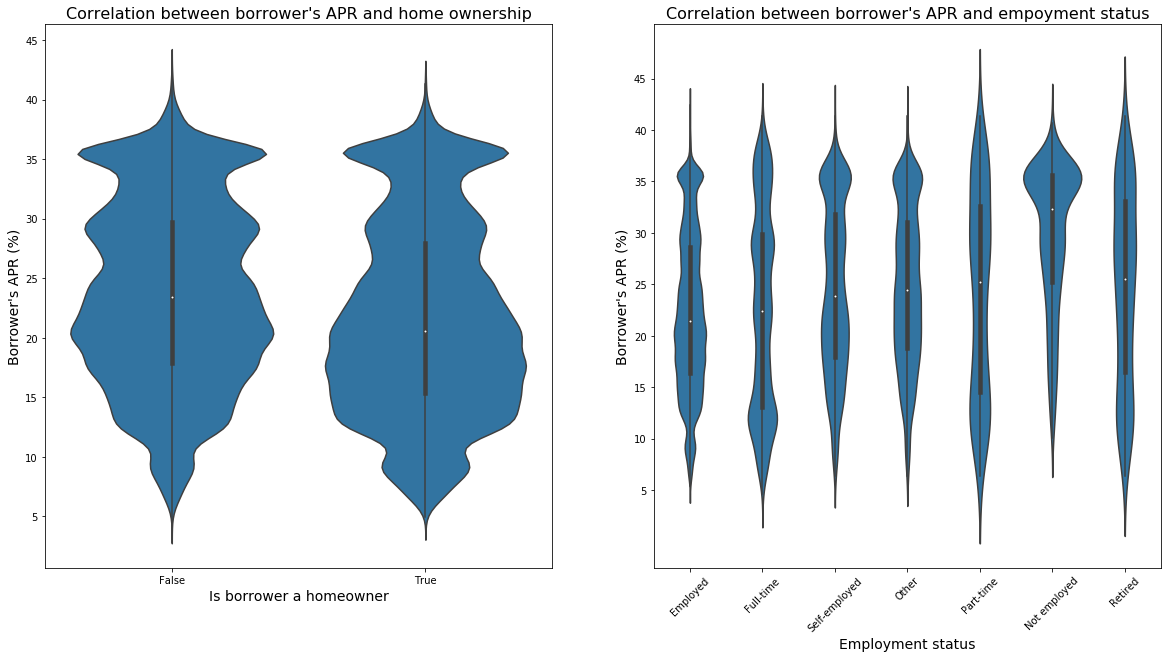

In [14]:
plt.figure(figsize = [20, 10])

# plot the correlation between borrower's APR and empoyment status
plt.subplot(1, 2, 1)
sns.violinplot(data = df, x='IsBorrowerHomeowner', y='BorrowerAPR', color=base_color)
x_y_t('Is borrower a homeowner', "Borrower's APR (%)", "Correlation between borrower's APR and home ownership")
plt.yticks([0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45], 
           ['5', '10', '15', '20', '25', '30', '35', '40', '45']);

plt.subplot(1, 2, 2)
sns.violinplot(data = df, x='EmploymentStatus', y='BorrowerAPR', color=base_color)
x_y_t('Employment status', "Borrower's APR (%)", "Correlation between borrower's APR and empoyment status")
plt.yticks([0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45], 
           ['5', '10', '15', '20', '25', '30', '35', '40', '45'])
plt.xticks(rotation = 45);

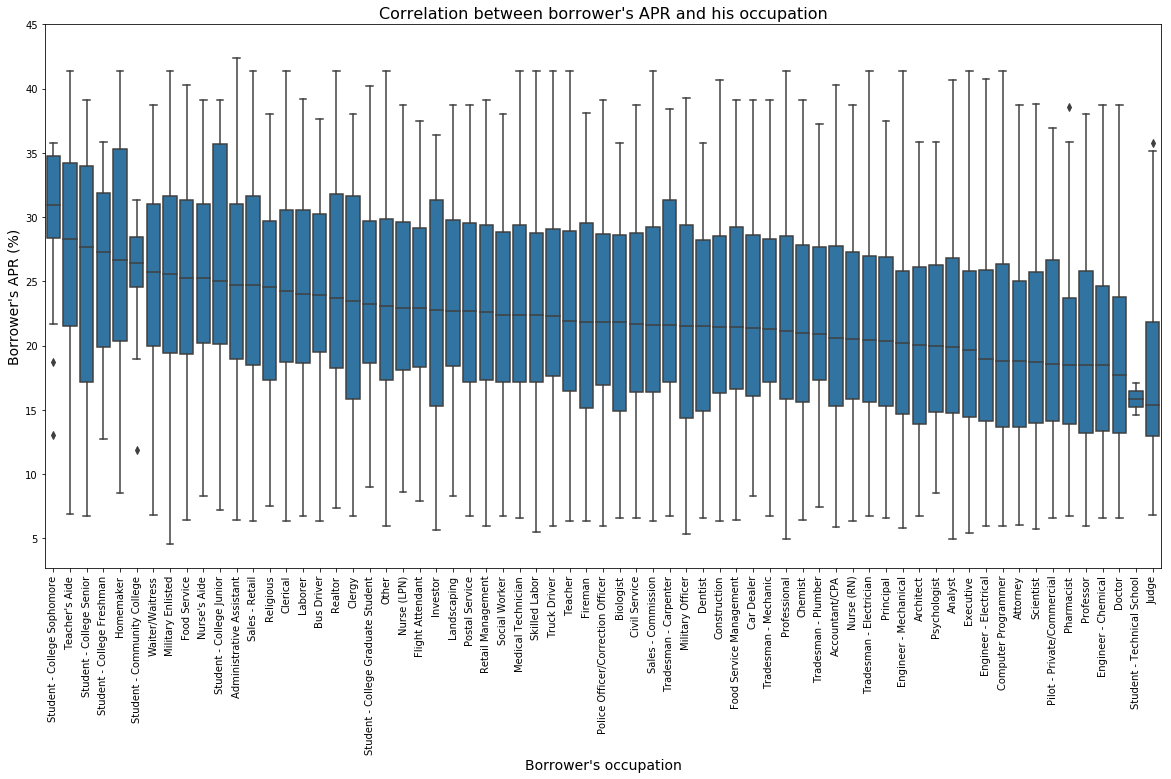

In [15]:
plt.figure(figsize = [20, 10])
listing_category_order = df.groupby('Occupation')['BorrowerAPR'].median().sort_values(ascending = False).index
sns.boxplot(data = df, y = 'BorrowerAPR', x = 'Occupation', color = base_color, order=listing_category_order)
x_y_t("Borrower's occupation", "Borrower's APR (%)", "Correlation between borrower's APR and his occupation")
plt.yticks([0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45], 
           ['5', '10', '15', '20', '25', '30', '35', '40', '45'])
plt.xticks(rotation = 90);

In [ ]:
# Use this command if you are running this file in local
!jupyter nbconvert Prosper_Loan_Part_II_slide_deck.ipynb --to slides --post serve --no-input --no-prompt

[NbConvertApp] Converting notebook Prosper_Loan_Part_II_slide_deck.ipynb to slides
[NbConvertApp] Writing 1075181 bytes to Prosper_Loan_Part_II_slide_deck.slides.html
[NbConvertApp] Redirecting reveal.js requests to https://cdnjs.cloudflare.com/ajax/libs/reveal.js/3.5.0
Serving your slides at http://127.0.0.1:8000/Prosper_Loan_Part_II_slide_deck.slides.html
Use Control-C to stop this server
/usr/bin/xdg-open: 778: /usr/bin/xdg-open: x-www-browser: not found
/usr/bin/xdg-open: 778: /usr/bin/xdg-open: firefox: not found
/usr/bin/xdg-open: 778: /usr/bin/xdg-open: iceweasel: not found
/usr/bin/xdg-open: 778: /usr/bin/xdg-open: seamonkey: not found
/usr/bin/xdg-open: 778: /usr/bin/xdg-open: mozilla: not found
/usr/bin/xdg-open: 778: /usr/bin/xdg-open: epiphany: not found
/usr/bin/xdg-open: 778: /usr/bin/xdg-open: konqueror: not found
/usr/bin/xdg-open: 778: /usr/bin/xdg-open: chromium-browser: not found
/usr/bin/xdg-open: 778: /usr/bin/xdg-open: google-chrome: not found
/usr/bin/xdg-open: 7